In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import nltk
from nltk.stem import PorterStemmer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [22]:
# Load the data
df = pd.read_csv("/content/EMAIL EDITED DATASE.csv", encoding="latin")
df.head()

,ï»¿message,prediction
0,"Dear Customer,Cash loan by Prefr from Rs.10,00...",financial
1,"Dear Customer, Rs.300,000 Cash Loan ready to b...",financial
2,"Dear customer, \ncongrats! Your moneyview pers...",financial
3,"Hey Vishnubhai , Your loan money of up to Rs 5...",financial
4,"Dear Customer,Avail Navi Cash Loan of up to Rs...",financial


In [23]:
#Rename columns
df=df.rename(
{
    "prediction":"Category",
    "ï»¿message":"Message"
},
    axis=1
)
df.head()

,Message,Category
0,"Dear Customer,Cash loan by Prefr from Rs.10,00...",financial
1,"Dear Customer, Rs.300,000 Cash Loan ready to b...",financial
2,"Dear customer, \ncongrats! Your moneyview pers...",financial
3,"Hey Vishnubhai , Your loan money of up to Rs 5...",financial
4,"Dear Customer,Avail Navi Cash Loan of up to Rs...",financial


In [24]:
df["Category"].value_counts()

promotional    361
fraud          360
phishing       360
ham            360
financial      359
Name: Category, dtype: int64

In [25]:
# Map categories to numerical labels
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "promotional":1,
        "financial":2,
        "phishing":3,
        "fraud":4
    }
)
df.head()

,Message,Category,Label
0,"Dear Customer,Cash loan by Prefr from Rs.10,00...",financial,2
1,"Dear Customer, Rs.300,000 Cash Loan ready to b...",financial,2
2,"Dear customer, \ncongrats! Your moneyview pers...",financial,2
3,"Hey Vishnubhai , Your loan money of up to Rs 5...",financial,2
4,"Dear Customer,Avail Navi Cash Loan of up to Rs...",financial,2


In [26]:
# Preprocess text using spaCy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]
    return ' '.join(tokens)

df['Message'] = preprocessed_texts = [preprocess_text(text) for text in df['Message']]

In [27]:
labels = df['Label']

**LSTM MODEL**

In [29]:
# Load and preprocess the data
X_text = df[['Message']]
y = df['Label']

# Combine the text data from the first seven columns into a single column
X_combined_text = X_text.apply(lambda row: ' '.join(row), axis=1)

# Tokenize the combined text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_combined_text)
sequences = tokenizer.texts_to_sequences(X_combined_text)

# Pad the sequences to ensure they have the same length
max_length_sequence = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length_sequence)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode the target values
num_classes = len(set(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define LSTM model architecture
TOT_SIZE = len(tokenizer.word_index) + 1  # Vocabulary size equal to the number of unique words
embedding_size = 200
model = Sequential()
model.add(Embedding(input_dim=TOT_SIZE, output_dim=embedding_size, input_length=max_length_sequence))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Train LSTM model on training set with callbacks
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                    epochs=40, batch_size=32, callbacks=[early_stopping])

# Evaluate LSTM model on validation set
loss_val, accuracy_val = model.evaluate(X_val, y_val_encoded)

# Evaluate LSTM model on test set
loss_test, accuracy_test = model.evaluate(X_test, y_test_encoded)

# Obtain training accuracy from the training history
train_accuracy = history.history['accuracy'][-1]

print("LSTM Model:")
print("Validation Loss:", loss_val)
print("Validation Accuracy:", accuracy_val)

print("Test Loss:", loss_test)
print("Test Accuracy:", accuracy_test)

print("Train Accuracy:", train_accuracy)


Epoch 1/40
40/40 [==============================] - 11s 207ms/step - loss: 1.3434 - accuracy: 0.5325 - val_loss: 0.6102 - val_accuracy: 0.8222
Epoch 2/40
40/40 [==============================] - 9s 234ms/step - loss: 0.3614 - accuracy: 0.9087 - val_loss: 0.2256 - val_accuracy: 0.9444
Epoch 3/40
40/40 [==============================] - 9s 216ms/step - loss: 0.1063 - accuracy: 0.9778 - val_loss: 0.1428 - val_accuracy: 0.9667
Epoch 4/40
40/40 [==============================] - 8s 188ms/step - loss: 0.0554 - accuracy: 0.9889 - val_loss: 0.0875 - val_accuracy: 0.9704
Epoch 5/40
40/40 [==============================] - 8s 208ms/step - loss: 0.0277 - accuracy: 0.9952 - val_loss: 0.0683 - val_accuracy: 0.9778
Epoch 6/40
40/40 [==============================] - 8s 211ms/step - loss: 0.0171 - accuracy: 0.9968 - val_loss: 0.0634 - val_accuracy: 0.9815
Epoch 7/40
40/40 [==============================] - 8s 189ms/step - loss: 0.0138 - accuracy: 0.9976 - val_loss: 0.0907 - val_accuracy: 0.9778
Epoch

**DENSE MODEL**

In [31]:
# Load and preprocess the data
X_text = df[['Message']]
y = df['Label']

# Combine the text data from the first seven columns into a single column
X_combined_text = X_text.apply(lambda row: ' '.join(row), axis=1)

# Tokenize the combined text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_combined_text)
sequences = tokenizer.texts_to_sequences(X_combined_text)

# Pad the sequences to ensure they have the same length
max_length_sequence = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length_sequence)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode the target values
num_classes = len(set(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define Dense model architecture
model_dense = Sequential()
model_dense.add(Embedding(input_dim=TOT_SIZE, output_dim=embedding_size, input_length=max_length_sequence))
model_dense.add(GlobalAveragePooling1D())
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(num_classes, activation='softmax'))
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping_dense = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Train Dense model on training set with callbacks
history_dense = model_dense.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                                epochs=40, batch_size=32, callbacks=[early_stopping_dense])

# Evaluate Dense model on validation set
loss_val_dense, accuracy_val_dense = model_dense.evaluate(X_val, y_val_encoded)

# Evaluate Dense model on test set
loss_test_dense, accuracy_test_dense = model_dense.evaluate(X_test, y_test_encoded)

# Obtain training accuracy from the training history
train_accuracy_dense = history_dense.history['accuracy'][-1]

print("Dense Model:")
print("Validation Loss:", loss_val_dense)
print("Validation Accuracy:", accuracy_val_dense)

print("Test Loss:", loss_test_dense)
print("Test Accuracy:", accuracy_test_dense)

print("Train Accuracy:", train_accuracy_dense)

Epoch 1/40
40/40 [==============================] - 1s 15ms/step - loss: 1.6058 - accuracy: 0.2405 - val_loss: 1.5949 - val_accuracy: 0.7222
Epoch 2/40
40/40 [==============================] - 0s 12ms/step - loss: 1.5801 - accuracy: 0.4079 - val_loss: 1.5575 - val_accuracy: 0.7852
Epoch 3/40
40/40 [==============================] - 0s 11ms/step - loss: 1.5164 - accuracy: 0.5381 - val_loss: 1.4582 - val_accuracy: 0.7037
Epoch 4/40
40/40 [==============================] - 0s 11ms/step - loss: 1.3675 - accuracy: 0.6421 - val_loss: 1.2435 - val_accuracy: 0.8259
Epoch 5/40
40/40 [==============================] - 0s 11ms/step - loss: 1.1063 - accuracy: 0.7270 - val_loss: 0.9599 - val_accuracy: 0.9185
Epoch 6/40
40/40 [==============================] - 0s 10ms/step - loss: 0.8582 - accuracy: 0.8103 - val_loss: 0.7257 - val_accuracy: 0.9000
Epoch 7/40
40/40 [==============================] - 0s 10ms/step - loss: 0.6668 - accuracy: 0.8460 - val_loss: 0.5416 - val_accuracy: 0.9444
Epoch 8/40
40

**BI-LSTM MODEL**

In [32]:
# Load and preprocess the data
X_text = df[['Message']]
y = df['Label']

# Combine the text data from the first seven columns into a single column
X_combined_text = X_text.apply(lambda row: ' '.join(row), axis=1)

# Tokenize the combined text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_combined_text)
sequences = tokenizer.texts_to_sequences(X_combined_text)

# Pad the sequences to ensure they have the same length
max_length_sequence = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length_sequence)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode the target values
num_classes = len(set(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


# Define Bidirectional LSTM model architecture
TOT_SIZE = len(tokenizer.word_index) + 1  # Vocabulary size equal to the number of unique words
embedding_size = 200
model_bidirectional = Sequential()
model_bidirectional.add(Embedding(input_dim=TOT_SIZE, output_dim=embedding_size, input_length=max_length_sequence))
model_bidirectional.add(Bidirectional(LSTM(128)))
model_bidirectional.add(Dense(64, activation='relu'))
model_bidirectional.add(Dropout(0.5))
model_bidirectional.add(Dense(num_classes, activation='softmax'))
model_bidirectional.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping_bidirectional = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Train Bidirectional LSTM model on training set with callbacks
history_bidirectional = model_bidirectional.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                                                epochs=40, batch_size=32, callbacks=[early_stopping_bidirectional])

# Evaluate Bidirectional LSTM model on validation set
loss_val_bidirectional, accuracy_val_bidirectional = model_bidirectional.evaluate(X_val, y_val_encoded)

# Evaluate Bidirectional LSTM model on test set
loss_test_bidirectional, accuracy_test_bidirectional = model_bidirectional.evaluate(X_test, y_test_encoded)

# Obtain training accuracy from the training history
train_accuracy_bidirectional = history_bidirectional.history['accuracy'][-1]

print("Bidirectional LSTM Model:")
print("Validation Loss:", loss_val_bidirectional)
print("Validation Accuracy:", accuracy_val_bidirectional)

print("Test Loss:", loss_test_bidirectional)
print("Test Accuracy:", accuracy_test_bidirectional)

print("Train Accuracy:", train_accuracy_bidirectional)


Epoch 1/40
40/40 [==============================] - 21s 423ms/step - loss: 1.3280 - accuracy: 0.4571 - val_loss: 0.7092 - val_accuracy: 0.7481
Epoch 2/40
40/40 [==============================] - 17s 429ms/step - loss: 0.4344 - accuracy: 0.8619 - val_loss: 0.1646 - val_accuracy: 0.9481
Epoch 3/40
40/40 [==============================] - 15s 381ms/step - loss: 0.1168 - accuracy: 0.9754 - val_loss: 0.1413 - val_accuracy: 0.9593
Epoch 4/40
40/40 [==============================] - 15s 384ms/step - loss: 0.1223 - accuracy: 0.9706 - val_loss: 0.1408 - val_accuracy: 0.9593
Epoch 5/40
40/40 [==============================] - 15s 382ms/step - loss: 0.0569 - accuracy: 0.9889 - val_loss: 0.1019 - val_accuracy: 0.9778
Epoch 6/40
40/40 [==============================] - 17s 426ms/step - loss: 0.0457 - accuracy: 0.9913 - val_loss: 0.1094 - val_accuracy: 0.9704
Epoch 7/40
40/40 [==============================] - 15s 383ms/step - loss: 0.0369 - accuracy: 0.9929 - val_loss: 0.1632 - val_accuracy: 0.9704

Model Comparision

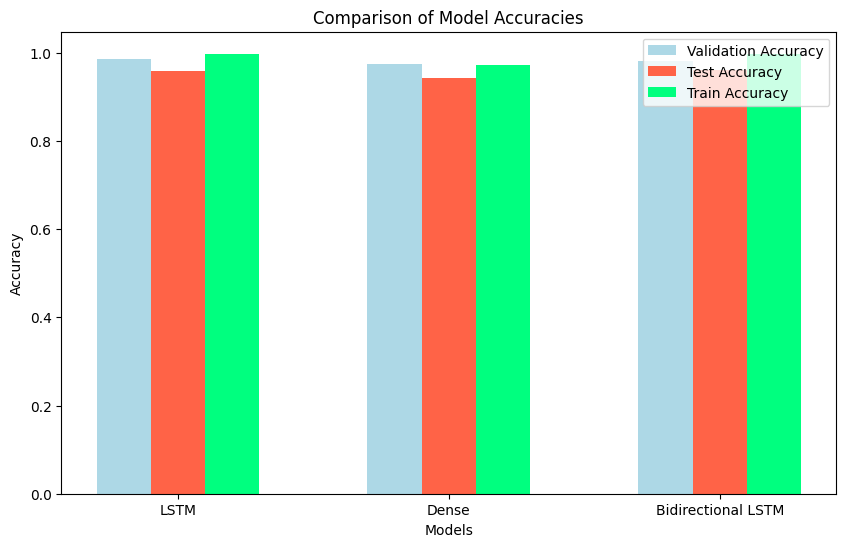

In [34]:
models = ['LSTM', 'Dense', 'Bidirectional LSTM']
val_accuracy = [0.985, 0.974, 0.981]  # Rounded validation accuracies
test_accuracy = [0.959, 0.944, 0.962]  # Rounded test accuracies
train_accuracy = [0.998, 0.973, 0.998]  # Rounded train accuracies

x = range(len(models))

plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(x, val_accuracy, width=bar_width, label='Validation Accuracy', color='lightblue', align='center')
plt.bar([i + bar_width for i in x], test_accuracy, width=bar_width, label='Test Accuracy', color='tomato', align='center')
plt.bar([i + 2 * bar_width for i in x], train_accuracy, width=bar_width, label='Train Accuracy', color='springgreen', align='center')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks([i + bar_width for i in x], models)
plt.legend()

plt.show()

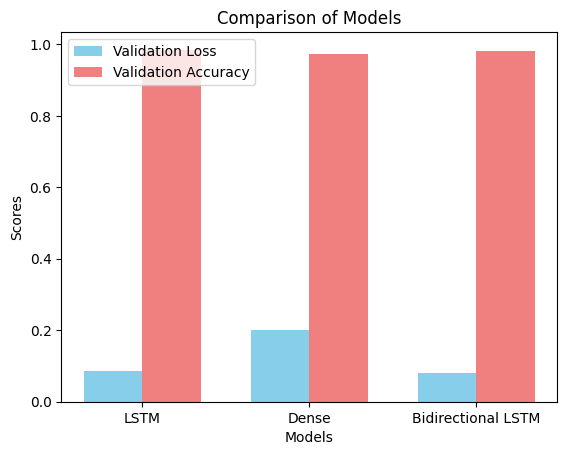

In [36]:
models = ['LSTM', 'Dense', 'Bidirectional LSTM']
val_loss = [0.086, 0.200, 0.080]  # Rounded off to three decimals
val_acc = [0.985, 0.974, 0.981]  # Rounded off to three decimals

# Plotting the bar graph
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.bar(index, val_loss, bar_width, label='Validation Loss', color='skyblue')
bar2 = ax.bar(index + bar_width, val_acc, bar_width, label='Validation Accuracy', color='lightcoral')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

plt.show()

